
Action	Direction
0	Left
1	Down
2	Right
3	Up

----------------------------------------------
Iteration: 1, Goal state: (3, 3)
Nodes Traversed: 9, Time Taken: 0.1423 ms
Path: [1, 1, 2, 1, 2, 2]
----------------------------------------------
Iteration: 2, Goal state: (2, 2)
Nodes Traversed: 7, Time Taken: 0.0892 ms
Path: [1, 1, 2, 2]
----------------------------------------------
Iteration: 3, Goal state: (1, 3)
Nodes Traversed: 11, Time Taken: 0.0944 ms
Path: [2, 2, 1, 2]
----------------------------------------------
Iteration: 4, Goal state: (3, 1)
Nodes Traversed: 6, Time Taken: 0.0582 ms
Path: [1, 1, 2, 1]
----------------------------------------------
Iteration: 5, Goal state: (2, 3)
Nodes Traversed: 9, Time Taken: 0.0577 ms
Path: [1, 1, 2, 2, 2]
----------------------------------------------


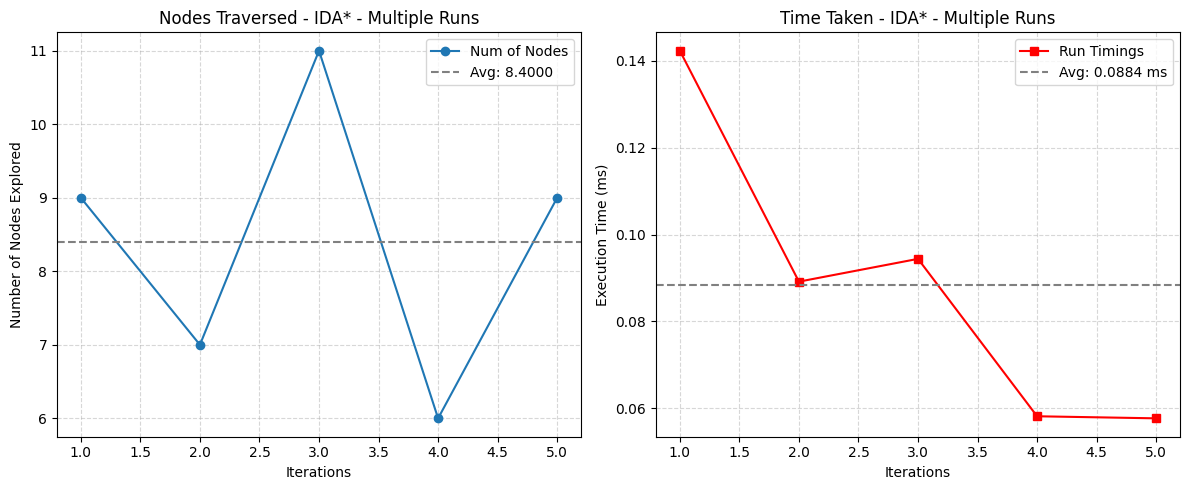

In [ ]:
import gymnasium as gym
import numpy as np
import imageio
import matplotlib.pyplot as plt
import time
from PIL import Image, ImageDraw
import random
import matplotlib.ticker as ticker

class FL_IDA_Star:
    """Solves the FrozenLake environment using IDA* algorithm."""

    def __init__(self, grid_size=4, target_pos=None):
        """Initialize solver with map size and goal position."""

        self.grid_size = grid_size

        if target_pos:
          self.target_pos = target_pos
        else:
          self.target_pos = (grid_size - 1, grid_size - 1)

        self.map_layout = self._generate_map(grid_size, self.target_pos)
        self.env = self._create_environment()
        self.animation_frames = []
        self.opt_path = None
        self.explored_states = []

    def _generate_map(self, size, target_pos):
        """Generate the FrozenLake map layout."""

        if size == 4:
            layout = [
                ['S', 'F', 'F', 'F'],
                ['F', 'H', 'F', 'H'],
                ['F', 'F', 'F', 'H'],
                ['H', 'F', 'F', 'F']
            ]
        else:
            layout = [['F'] * size for _ in range(size)]

        target_row, target_col = target_pos
        layout[target_row][target_col] = 'G'

        return layout

    def _create_environment(self):
        """Create and return the FrozenLake environment."""

        return gym.make(
            'FrozenLake-v1',
            desc=self.map_layout,
            is_slippery=False,
            render_mode='rgb_array'
        )

    def _calculate_heuristic(self, state):
        """Calculate Manhattan distance heuristic."""

        row, col = state // self.grid_size, state % self.grid_size
        target_row, target_col = self.target_pos
        x_cord = abs(row - target_row)
        y_cord = abs(col - target_col)
        man_hat = x_cord + y_cord
        return man_hat

    def _is_target_state(self, state):
        """Check if current state is the goal state."""

        row, col = state // self.grid_size, state % self.grid_size
        return (row, col) == self.target_pos

    def _get_state_transitions(self, state):
        """Get possible transitions from current state."""

        transitions = []
        for move in range(4):
            transition = self.env.unwrapped.P[state][move][0]
            transitions.append((move, transition[1], 1))
        return transitions

    def _perform_search(self, state, cost, threshold, path, visited):
        """Recursive search for IDA* algorithm."""

        self.explored_states.append(state)
        total_cost = cost + self._calculate_heuristic(state)

        if total_cost > threshold:
            return total_cost
        if self._is_target_state(state):
            return 'FOUND'

        min_bound = float('inf')
        visited.add(state)

        for action, next_state, step_cost in self._get_state_transitions(state):
            if next_state not in visited:
                path.append(action)
                result = self._perform_search(
                    next_state,
                    cost + step_cost,
                    threshold,
                    path,
                    visited
                )

                if result == 'FOUND':
                    return 'FOUND'
                if result < min_bound:
                    min_bound = result
                path.pop()

        visited.remove(state)
        return min_bound

    def find_path(self, initial_state):
        """Execute IDA* search from initial state."""

        threshold = self._calculate_heuristic(initial_state)
        path = []
        visited_nodes = set()

        while True:
            result = self._perform_search(
                initial_state,
                0,
                threshold,
                path,
                visited_nodes
            )

            if result == float('inf'):
                return None
            elif result == 'FOUND':
                return path
            threshold = result

    def _add_text_to_frame(self, frame, step, total_steps):
        """Add step and goal information to animation frame."""

        img = Image.fromarray(frame)
        draw = ImageDraw.Draw(img)
        draw.text((10, 10), "Step {0}/{1}".format(step, total_steps), fill='black')
        draw.text((10, 30), "Goal: {0}".format(self.target_pos), fill='black')
        return np.array(img)

    def create_animation(self, run_id):
        """Generate solution animation."""

        frames = []
        temp_env = self._create_environment()
        current_state = temp_env.reset(seed=42 + run_id)[0]
        frames.append(temp_env.render())

        for step, action in enumerate(self.opt_path):
            current_state = temp_env.step(action)[0]
            frame = temp_env.render()
            frame_with_text = self._add_text_to_frame(frame, step + 1, len(self.opt_path))
            frames.append(frame_with_text)

        # Add final frames for visualization
        frames.extend([temp_env.render()] * 10)

        # Save animation
        imageio.mimsave(f'ida_star_{run_id + 1}.gif', frames, duration=3)

    def execute_solution(self, seed_value, run_id):
        """Run solver and return performance metrics."""

        initial_state = self.env.reset(seed=seed_value)[0]
        self.explored_states = []
        start_time = time.time()
        self.opt_path = self.find_path(initial_state)
        end_time = time.time()

        if self.opt_path:
            self.create_animation(run_id)

        return len(self.explored_states), self.opt_path, end_time - start_time

def visualize_results(iterations, nodes, times):
    """Plot performance metrics with averages, save combined and individual plots."""

    def create_plot(x, y, avg, ylabel, label_leg, title, color, marker, filename, y_suffix=""):
        plt.figure()
        plt.plot(x, y, marker=marker, linestyle='-', color=color, label=label_leg)
        plt.axhline(y=avg, color='gray', linestyle='--', label=f"Avg: {avg:.4f}{y_suffix}")
        plt.xlabel("Iterations")
        plt.ylabel(ylabel)
        plt.title(title)
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
        plt.tight_layout()
        plt.savefig(filename, dpi=300)
        plt.close()

    avg_nodes = sum(nodes) / len(nodes)
    avg_time_ms = (sum(times) / len(times)) * 1000
    x_vals = list(range(1, iterations + 1))
    times_ms = [t * 1000 for t in times]

    # --- Combined Subplots ---
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Subplot: Nodes Explored
    axs[0].plot(x_vals, nodes, marker='o', linestyle='-', label="Num of Nodes")
    axs[0].axhline(y=avg_nodes, color='gray', linestyle='--', label=f"Avg: {avg_nodes:.4f}")
    axs[0].set_xlabel("Iterations")
    axs[0].set_ylabel("Number of Nodes Explored")
    axs[0].set_title("Nodes Traversed - IDA* - Multiple Runs")
    axs[0].grid(True, linestyle='--', alpha=0.5)
    axs[0].legend()

    # Subplot: Execution Time
    axs[1].plot(x_vals, times_ms, marker='s', linestyle='-', color='r', label="Run Timings")
    axs[1].axhline(y=avg_time_ms, color='gray', linestyle='--', label=f"Avg: {avg_time_ms:.4f} ms")
    axs[1].set_xlabel("Iterations")
    axs[1].set_ylabel("Execution Time (ms)")
    axs[1].set_title("Time Taken - IDA* - Multiple Runs")
    axs[1].grid(True, linestyle='--', alpha=0.5)
    axs[1].legend()

    plt.tight_layout()
    plt.savefig("ida_star_combined.png", dpi=300)
    plt.show()

    # --- Save individual plots ---
    create_plot(
        x_vals, nodes, avg_nodes,
        ylabel="Number of Nodes Explored",
        label_leg="Num of Nodes",
        title="Nodes Traversed - IDA* - Multiple Runs",
        color='blue', marker='o',
        filename="ida_star_nodes_trav.png"
    )

    create_plot(
        x_vals, times_ms, avg_time_ms,
        ylabel="Execution Time (ms)",
        label_leg="Run Timings",
        title="Time Taken - IDA* - Multiple Runs",
        color='red', marker='s',
        filename="ida_star_timeplot.png",
        y_suffix=" ms"
    )


def main():
    """Execute multiple runs with different goal positions."""

    num_runs = 5
    explored_nodes = []
    execution_times = []
    goal_locations = [(3, 3), (2, 2), (1, 3), (3, 1), (2, 3)]

    print("\nAction\tDirection")
    print("0\tLeft")
    print("1\tDown")
    print("2\tRight")
    print("3\tUp\n")
    print("----------------------------------------------")

    for run_num in range(num_runs):
        solver = FL_IDA_Star(
            grid_size = 4,
            target_pos = goal_locations[run_num]
        )
        nodes, solution, duration = solver.execute_solution(
            seed_value = 42 + run_num,
            run_id=run_num
        )

        explored_nodes.append(nodes)
        execution_times.append(duration)

        print("Iteration: {0}, Goal state: {1}".format(run_num + 1, solver.target_pos))
        print("Nodes Traversed: {0}, Time Taken: {1:.4f} ms".format(nodes, duration * 1000))
        print("Path: {0}".format(solution))
        print("----------------------------------------------")

    visualize_results(num_runs, explored_nodes, execution_times)

if __name__ == "__main__":
    main()